# Group 36 Project Report

### Group Members: Bhavtej Bhasin, Peter Chen, Theresa Choi, Sky Langille
### DSCI 100 004

Please run the cell below to load the necessary libraries and the data set.

In [37]:
#loading libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## K-Nearest Neighbor Regression Model for University Ranking Based on the Ratio of Students per Staff Students.

**Introduction:**

Incoming university students all over the world make their decision on which post-secondary institution to study at every year. These decisions are made on a number of factors, including the quality of teaching and programs offered, class size, geographical location, and often the rank and prestige of the university itself. Luckily, data sets with university ranking and a number of these factors are readily available online. Here, we use the University Rankings 2023 data set publicly available on Kaggle, published by Syed Ali Taqi, to conduct an analysis on university ranking and the ratio of students per staff. More specifically, can the global ranking of a university institution be determined through a K-Nearest Neighbor Regression Model based on the number of students per staff member?

The University Rankings 2023 data set includes global rankings for over 1500 post secondary institutions globally, as well as statistics for each institution including `University Rank`, `Number of students`, `Number of students per staff`, and more.

The names and locations of the universities are also listed in separate columns. Here we will only be using the University Rank, University Name and Number of students per staff columns in our analysis.

**Methods & Results:**


Before we can do any analysis on for the regression, we must take our original data set and tidy up the necessary data and columns for our analysis. First, we will load our data set into R. This can be achieved using the `read_csv()` function to call on the data set we loaded into GitHub.

In [38]:
#loading the dataset into R
url <- "https://raw.githubusercontent.com/petercmh01/DSCI_004_Group_36/main/World%20University%20Rankings%202023.csv"

university_data <- read_csv(url)
university_data

Rows: 2341 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): University Rank, Name of University, Location, International Stude...
dbl  (1): No of student per staff
num  (1): No of student

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


University Rank,Name of University,Location,No of student,No of student per staff,International Student,Female:Male Ratio,OverAll Score,Teaching Score,Research Score,Citations Score,Industry Income Score,International Outlook Score
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,University of Oxford,United Kingdom,20965,10.6,42%,48 : 52,96.4,92.3,99.7,99.0,74.9,96.2
2,Harvard University,United States,21887,9.6,25%,50 : 50,95.2,94.8,99.0,99.3,49.5,80.5
3,University of Cambridge,United Kingdom,20185,11.3,39%,47 : 53,94.8,90.9,99.5,97.0,54.2,95.8
3,Stanford University,United States,16164,7.1,24%,46 : 54,94.8,94.2,96.7,99.8,65.0,79.8
5,Massachusetts Institute of Technology,United States,11415,8.2,33%,40 : 60,94.2,90.7,93.6,99.8,90.9,89.3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-,University of the West of Scotland,NA,NA,NA,NA,NA,34.0–39.2,24.1,15.5,61.5,37.9,76.8
-,University of Windsor,NA,NA,NA,NA,NA,34.0–39.2,35.1,29.4,34.5,44.2,88.7
-,University of Wolverhampton,NA,NA,NA,NA,NA,34.0–39.2,18.2,14.3,68.8,37.3,72.0


The original data set column names are not ideal for using and wrangling in code. Thus we rename any columns we are using to fit our needs. This includes the `University Rank`, `Name of University`, and `Number of Students per Staff` columns from the original data set.

In [40]:
#rename relevant columns
university_rename <- university_data |>
    rename(
       "university_rank" = "University Rank",
        "name_of_university" = "Name of University",
        "number_students_per_staff" = "No of student per staff"
    )

Now, we can begin organizing our data. We do not need all the columns from the original University Ranks 2023 data set, thus we will create a new data frame containing only the  `university_rank`, `name_of_university`, `number_of_students` and `number_students_per_staff` columns. 

Not every university on the rankings list received a ranking and we cannot use Reporter institutions for this analysis, so we will filter for rows where `university_rank` is not "Reporter". Next, we will filter for only complete cases in the `number_students_per_staff` column. Finally, we convert the `university_rank` column to be numeric variables rather than character variables and drop any rows where university rank is then not applicable, or "NA".

Some universities only received rankings in a range such as "201-250" or "1500+". Ranges like these will be unreliable to use in our data analysis, and so should be filtered out. This leaves us with a significantly smaller data set of 198 rows.

In [41]:
university_student_stats <- university_rename |> #create tibble with only relvant columns
    select(university_rank, name_of_university, number_students_per_staff) |>
    filter(university_rank != "Reporter") |> #filter out unranked universities
    filter(complete.cases(number_students_per_staff)) |> #filter out universities that did not report a student ratio
    mutate(university_rank = as.numeric(university_rank)) |>
    drop_na(university_rank) #filter out universities whose ranks are ranges (eg. 201-250)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `university_rank = as.numeric(university_rank)`.
Caused by warning:
! NAs introduced by coercion”


To finish up our initial data wrangling, we will create a new data frame with only the University Rank and Number of Students per Staff by selecting only these columns. Here we name this data frame `university_rank_students`.

In [43]:
#separate tibble with only univeristy rank and number of students per staff.
university_rank_students <- university_student_stats |>
    select(university_rank, number_students_per_staff)
university_rank_students

university_rank,number_students_per_staff
<dbl>,<dbl>
1,10.6
2,9.6
3,11.3
3,7.1
5,8.2
⋮,⋮
196,43.4
196,15.8
198,14.1


Below we have generated a scatterplot visualization of University Rank against the Number of Students per Staff to demonstrate our entire original data before any analysis. This can allow us a preliminary visualization and understanding of what our expected results may be upon visual inspection of the data.

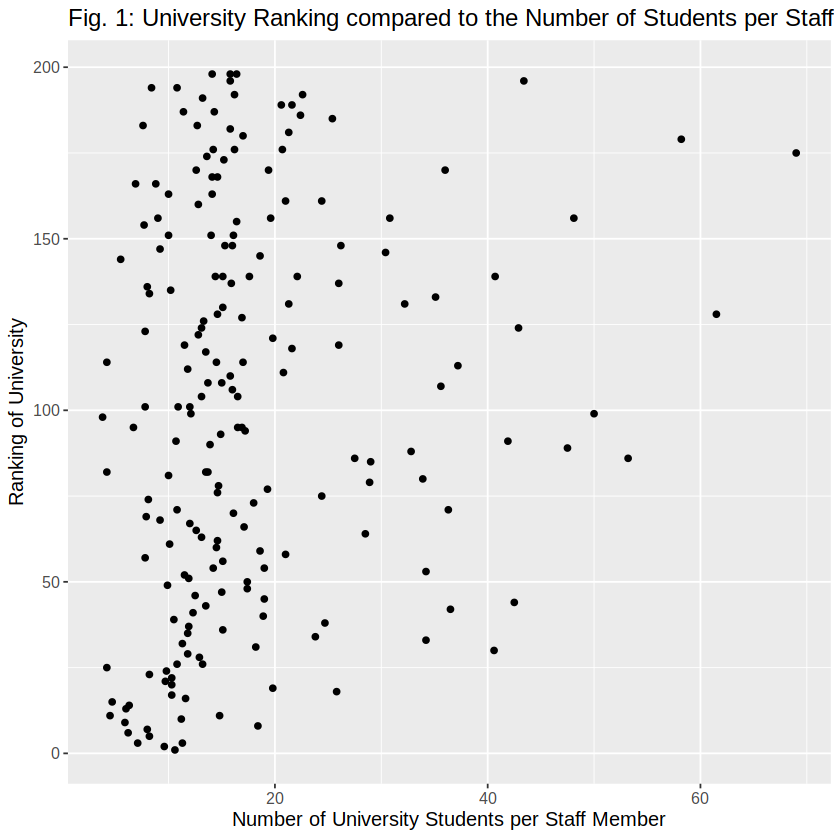

In [44]:
rank_student_plot <- university_rank_students |> 
    ggplot(aes(x = number_students_per_staff, y = university_rank)) +
    geom_point() +
    xlab("Number of University Students per Staff Member") +
    ylab("Ranking of University") +
    ggtitle("Fig. 1: University Ranking compared to the Number of Students per Staff") +
    theme(text = element_text(size=12))
rank_student_plot

The Figure 1 above shows the majority of the Number of Students per Staff is approximately below 30. However, a weak positive relationship can be seen just by visual inspection as a fair number of university rankings increase as the Number of Students per Staff Member increases. In the context of University Rankings, lower rankings (ie: 1, 2, 3 etc) are preferred to higher rankings (ie: 50, 60, 100).

Now, we can begin our data analysis and create a K-Nearest Neighbor Regression Model to predict University Ranking based on the Number of Students per Staff member. This starts with setting the seed to ensure analysis is reproducible, then creating the testing and training data sets. This is seen in the code cell below:

In [47]:
set.seed(2023) #set seed DO NOT CHANGE!

university_split <- initial_split(university_rank_students, prop = 0.70, strata = university_rank)
university_training <- training(university_split)
university_testing <- testing(university_split)

Given our initial data set only contains 198 rows, we decided a 70-30 ratio split between the training and testing data sets would be appropriate to ensure enough data would be available to create an efficient and usable model. Below we have included a summarizing table showing the number of observations in the training data set and the average number of students per staff of training set data.

In [48]:
#summarize training set in one table
training_table <- university_training |>
    mutate(number_training_obs = nrow(university_training)) |>
    mutate(average_student_ratio = mean(number_students_per_staff)) |>
    select(number_training_obs, average_student_ratio) |>
    slice(1)
training_table

number_training_obs,average_student_ratio
<int>,<dbl>
139,16.40935


The training set data has 139 observations and an average Number of Students per Staff of 16.41. Next we will visualize the training set in a scatterplot graph below.

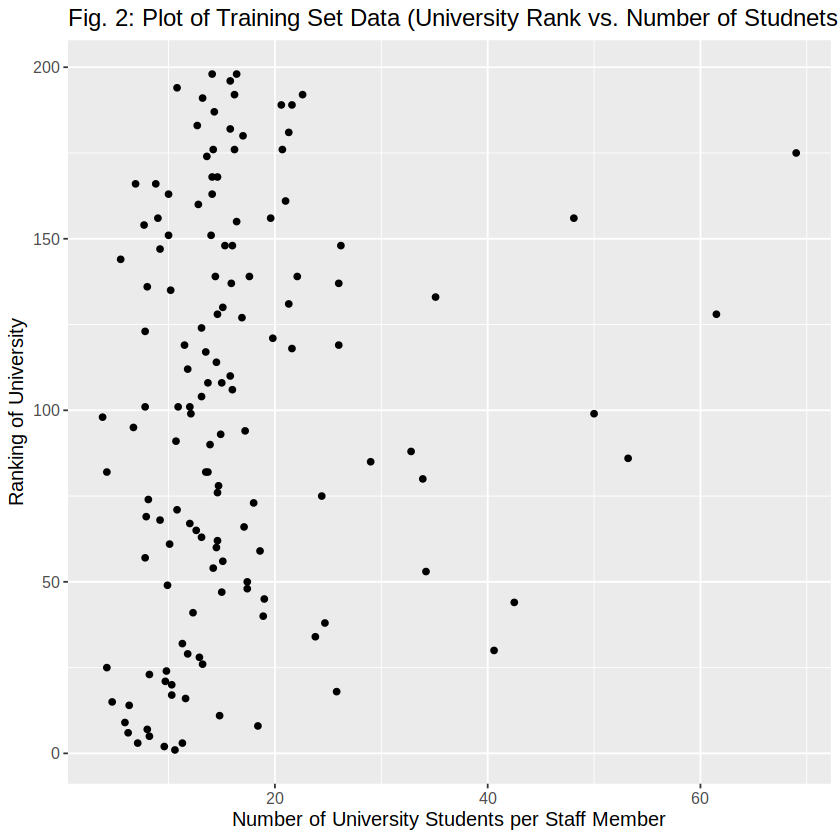

In [50]:
university_training_plot <- university_training |> 
    ggplot(aes(x = number_students_per_staff, y = university_rank)) +
    geom_point() +
    xlab("Number of University Students per Staff Member") +
    ylab("Ranking of University") +
    ggtitle("Fig. 2: Plot of Training Set Data (University Rank vs. Number of Studnets per Staff)") +
    theme(text = element_text(size=12))
university_training_plot

Figure 2 above is fairly similar to the visualization of the original data set with a weak positive relationship between university ranking and the number of students per staff.

Now, we can start building our regression model. This begins with setting the recipe and specifications for our regression model as we have done in the cell below. The recipe will allow our data to be pre-processed prior to applying our regression model. Our recipe is set to determine University Rank based on the Number of Students per Staff variable from the training data set, with all predictors scaled. Our specification for this model has been set to tune as we will first tune the regression model to find the ideal K-value with 5-Fold Cross Validation, simply named `spec` below.

In [11]:
recipe <- recipe(university_rank ~ number_students_per_staff, data = university_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

To create the best model possible using the ideal K-value, we will use 5-Fold Cross Validation to test K-values from 1 to 50. Below we have set up the 5-Fold Cross Validation as well as the workflow for our regression model.

We have loaded both our recipe and specification from above for the workflow to chain these steps together automatically without us needing to code the regression model to follow the recipe and specification ourselves.

In [12]:
vfold <- vfold_cv(university_training, v = 5, strata = university_rank)

workflow <- workflow() |>
  add_recipe(recipe) |>
  add_model(spec)

workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next we will perform the 5-Fold Cross Validation and collect the metrics for the Root Mean Squared Prediction Error (RMSPE) for the training data set, which is the RMSE value collected by the `collect_metrics()` function. Below we have generated a tibble showing the RMSE value for K-values 1 to 50.

In [13]:
set.seed(2023)

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

results <- workflow |>
  tune_grid(resamples = vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

# show the regression results
results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,63.23115,5,3.142098,Preprocessor1_Model01
2,rmse,standard,56.14306,5,2.458279,Preprocessor1_Model02
3,rmse,standard,54.90031,5,3.083260,Preprocessor1_Model03
4,rmse,standard,53.00977,5,3.421523,Preprocessor1_Model04
5,rmse,standard,52.66659,5,3.085874,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,rmse,standard,56.36020,5,1.395974,Preprocessor1_Model46
47,rmse,standard,56.37105,5,1.326253,Preprocessor1_Model47
48,rmse,standard,56.38007,5,1.213677,Preprocessor1_Model48


The ideal K-value to use would be the one which gives us the minimum RMSE value. We can find this K-value easily by filtering the `mean` column from the tibble above, which is the RMSE value, and pulling the value in the `neighbors` column associated with the observation with the lowest mean value. This will give us our ideal K-value named `kmin` below.

In [14]:
kmin <- results |>
    filter(mean == min(mean)) |>
    pull(neighbors)
kmin

[1] 5

Performing the steps outlined above gives us an ideal K-value of $K = 5$ with the lowest RMSE value of 52.66659. To confirm this, we can generate a plot visualizing the RMSE values from our 5-Fold Cross Validation. This is seen below in the plot titled "RMSE agains the Number of Neighbors used in Regression". Analyzing this plot we can see that 5 neighbors, or $K = 5$, is the ideal K-value. Visual inspection of the plot shows us that the minimum RMSE is obtained using $K = 5$.

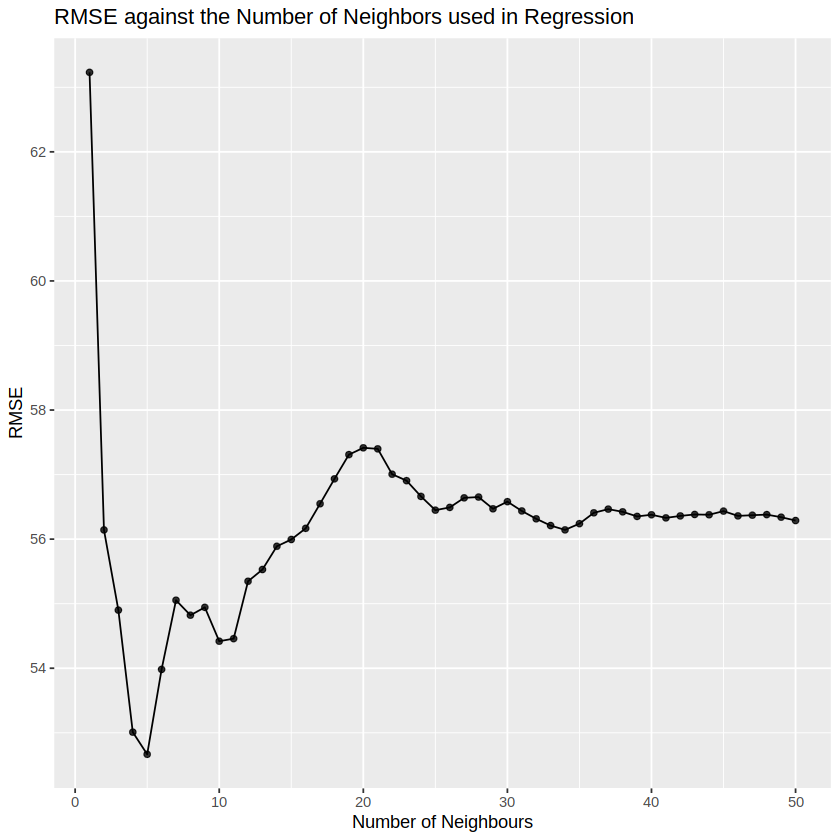

In [15]:
# plot the result (number of neighbours and RMSE score)
rmse_plot <- ggplot(results, aes(x = neighbors, y = mean)) +
    geom_point(alpha = 0.8) +
    geom_line() +
    xlab("Number of Neighbours") +
    ylab("RMSE") +
    ggtitle("RMSE against the Number of Neighbors used in Regression")

rmse_plot

Now that we have determined $K = 5$ to be our ideal K-value, we can create our regression model with the determined number of neighbors and test it using the testing data set, `university_testing`.

To create our final regression model, we can start coding a new specification, which we call `final_spec` below, and setting the neighbors value to be our `kmin` value from above. Below we have used `kmin`, but we can see above that this means our regression will be performed using the 5 nearest neighbors for each point. Next, we can recreate the workflow for the regression model with our new specification. We can re-use the same recipe from the training model as we have previously defined it above. Lastly, we fit the data to the `university_training` data to keep the test data set, `university_testing`, separate from the regression model to use afterwards to determine the model's accuracy. We have called this `final_fit` in the cell below.

In [ ]:
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

final_fit <- workflow() |>
  add_recipe(recipe) |>
  add_model(final_spec) |>
  fit(data = university_training)

We can test the regression model's ability to predict university rankings using the provided number of students per staff from a given university. To do this, we will use the `predict()` function on the `university_testing` data set with the `final_fit` regression model we constructed above.

This allows the regression model to predict university rank on the testing data set, `university_testing`. Next we use the `bind_cols()` function to seamlessly combine the results of the prediction to the `university_testing` data frame by adding a new column with the predicted university rankings generated through K-nearest neighbor regression. 

In [16]:
final_preds <- final_fit |>
  predict(university_testing) |>
  bind_cols(university_testing)
final_preds

ERROR: Error in predict(final_fit, university_testing): object 'final_fit' not found


The metrics function allows us to call statistics, such as the RMSE value, for the performed regression, and filtering only for the RMSE value we can get a sense of how well fitted our regression model is. The tibble above shows us the Root Mean Squared Error for the estimated university rankings predicted in our regression model. Here, it is 97.3266.

In [ ]:
final_summary <- final_preds |>
  metrics(truth = university_rank, estimate = number_students_per_staff) |>
  filter(.metric == 'rmse')

final_summary

Finally, we can generate a scatterplot to visualize our predicted university rankings from their associated number of students per staff using only the testing data. On the x-axis we have the number of students per staff and on the y-axis their true university rank. The blue line overlaid on the scatterplot shows the predicted university ranking from the regression model.

In [ ]:
plot_final <- ggplot(university_testing, aes(x = number_students_per_staff, y = university_rank)) +
  geom_point()+
  geom_line(data = final_preds, 
            mapping = aes(x = number_students_per_staff, y = .pred), 
            color = "blue") +
  xlab("Number of Students per Staff") +
  ylab("University Ranking") +
  ggtitle("Predicted University Ranking from Number of Students per Staff (K = 5)") + 
  theme(text = element_text(size = 12))

plot_final

As we can see in the visualization above of our test data set, `university_testing`, the regression model appears to be overfitted and our model has been influenced too much by the training data. This may be due to the small sample size of our data set or potentially an improper K-value selection. Further analysis of our findings will be in the Discussion section.

**Discussion:** 
  
*theresa is editing the discussion, it will be up soon if you're seeing this*

**References:**
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).- 
- Make sure to cite the source of your data as well.